In [3]:
import numpy as np
import io
import os
import requests
#import ee
import shapely
import geopandas as gpd
from tqdm import tqdm
from glob import glob
import random
import shutil
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import from_levels_and_colors
from skimage.io import imread
import rasterio as rio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

##### country shapefile from the https://gadm.org/download_country.html
##### sentinel 2 cloud free mosaics
##### land cover class from the ESA landcover classification layer `bear in mind that this is just for the sake of excercise that the dataset has lots of inaccuracies given byitself the data is the poutput of model prediction`

Initialize google earth engine python API and authenticate the google account. Please bear in mind that if you do not have google account the API is not working

In [55]:
ee.Authenticate()
ee.Initialize()

# Read the fishnet and bounday polygons as geopandas geodataframe 

In [9]:
full = gpd.read_file('/GORILLA/fishnet/fish_512.shp')  # a fishnet for full Uganda witha tile size of 512 by 512 rows and colums each, one pixel 10m by 10m
train = gpd.read_file('/GORILLA/fishnet/train_val.shp') # tiles selected for training and validation of training process
test_transfer = gpd.read_file('/GORILLA/fishnet/test_transfer.shp') # tiles selected for test or transfer
first_polygon = gpd.read_file('/GORILLA/gadm41_UGA_shp/gadm41_UGA_1.shp') # level 1 polygons to extract country boundary bounding boxes to extract images

# Visualize the samples with polygon layer

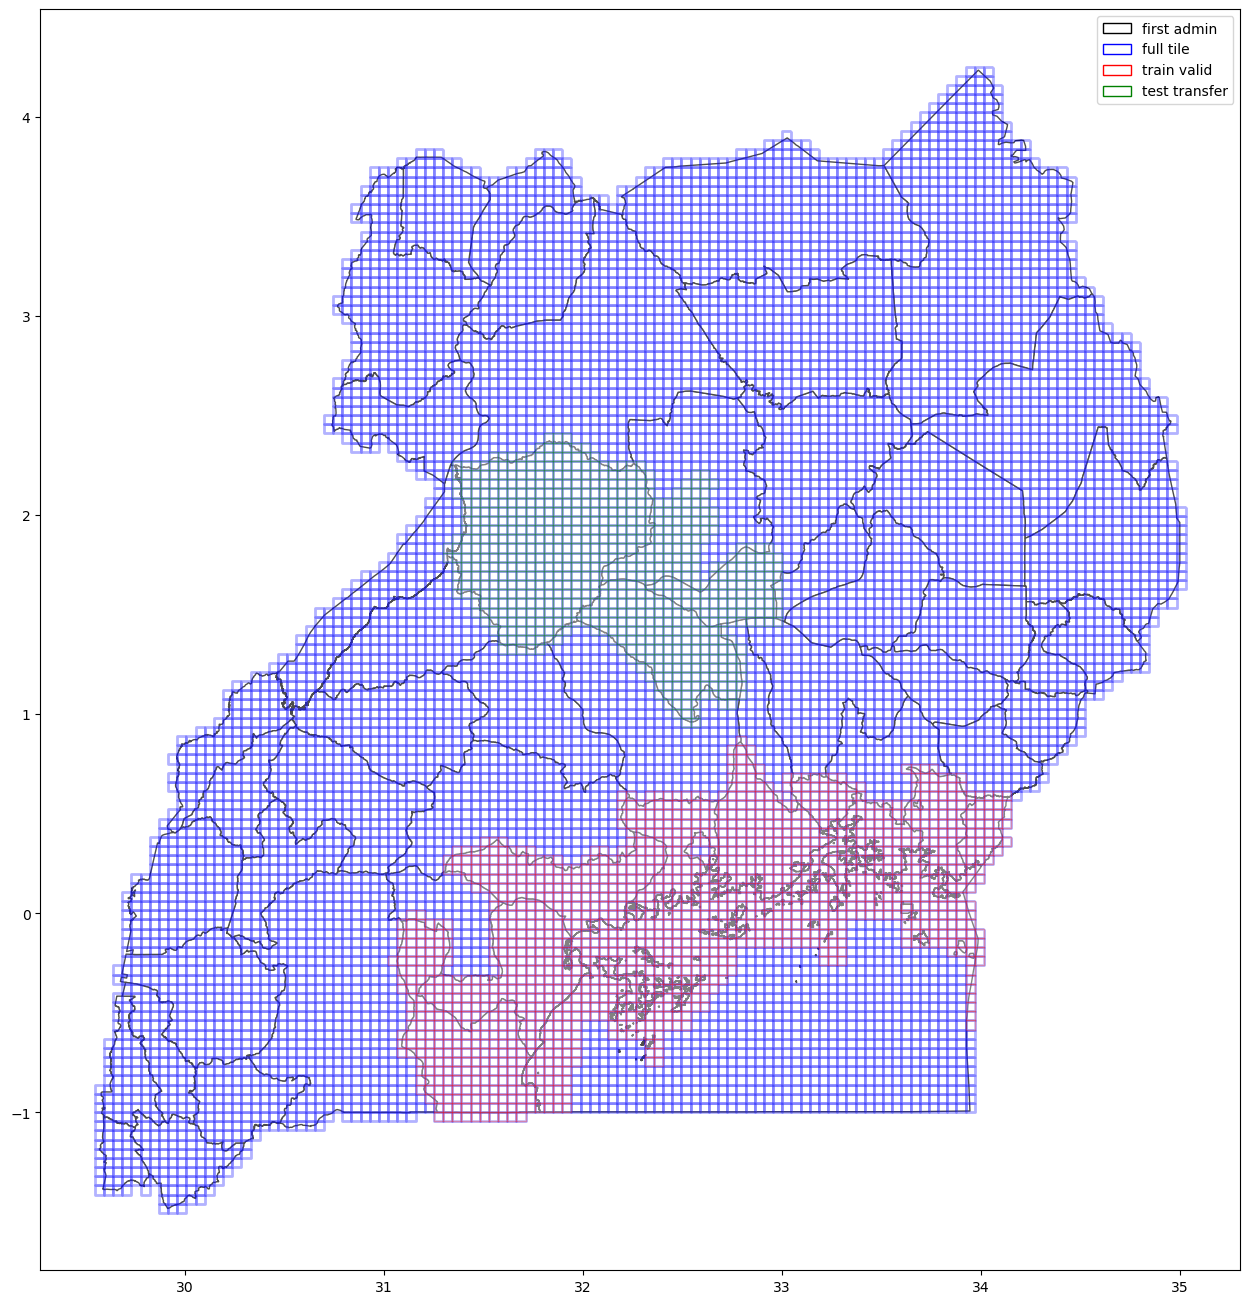

In [11]:
fig = plt.figure(figsize=(12,22))
ax = fig.add_axes([0, 0, 1, 1])
first_polygon.plot(ax=ax, facecolor="white", edgecolor="black",linewidth=1, label='first admin')
full.plot(ax=ax, facecolor="white", edgecolor="blue",linewidth=2, alpha=0.3, label='full tile')
train.plot(ax=ax, facecolor="white", edgecolor="red",linewidth=1, alpha=0.3, label='train valid')
test_transfer.plot(ax=ax, facecolor="white", edgecolor="green",linewidth=1, alpha=0.3, label='test transfer')
names = ['first admin', 'full tile','train valid', 'test transfer']
colors = ["black", "blue", "red", "green"]
handles = []
for pair in list(zip(colors, names)):
    handles.append(mpatches.Patch(edgecolor=pair[0], label=pair[1], fill=False))

plt.legend(handles=handles)
plt.show()

## Get each tile parameters(`GRID_ID` and `geometry`)

In [56]:
def get_tile_params(file='/GORILLA/fishnet/fish_512.shp', report=False):
    aa = gpd.read_file(file)
    geoms = [geom.bounds for geom in aa.geometry]  # geopandas shapely geometry bounds prmitive contains xmin, ymin, xmax, ymax
    names = list(aa['GRID_ID'])
    if report:
        print(names)
    return list(zip(geoms, names))

## Get the bounding geometry of the polygon

In [57]:
def getBoundGeom(file='/GORILLA/gadm41_UGA_shp/gadm41_UGA_0.shp'):
    file_r = gpd.read_file(file)
    bbox = file_r.geometry[0].bounds  # use this for google earth search engine
    return ee.Geometry.BBox(*bbox)

## Cloud masking using qulaity layer
##### Please note that its also possible to use cloud probability layer which provided as an additional product. This is upto the user to what quality levele to enforce in the product

In [58]:
def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    high_p = 1<<9
    med_p = 1<<8
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0)).And(qa.bitwiseAnd(high_p).eq(0)).And(qa.bitwiseAnd(med_p).eq(0))
    return image.updateMask(mask).divide(10000)

## Write the specific google earth engine ee.Image product in a specified image tile into the local disk or cloud bucket(`see also the documetation`)

In [59]:
def mass_write_image(g_n_pairts, image, out_dir,  bands=['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8', 'B8A'], scale=10, im_format='GEO_TIFF'):
    '''Bands 3(B), 4(G), 5(R) and 8(NIR) are 10 meters resolution. For details on bands see https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED '''
    
    if not os.path.exists(out_dir):
        os.makedirs(out_dir, exist_ok=True)
        
    for i in tqdm(range(len(g_n_pairts))):
        cord_bounds, name = g_n_pairts[i]
        region = ee.Geometry.BBox(*cord_bounds)
        name = f'{out_dir}/{name}.tif'
        
        url = image.getDownloadUrl({
            'bands': bands,
            'region': region,
            # 'scale': scale,
            'format': im_format,
            'dimensions':'512x512'
        })
        
        response = requests.get(url)
        
        with open(name, 'wb') as tile:
            tile.write(response.content)

## Write the specific google earth engine ee.Image [**Land cover product**] product in a specified image tile into the local disk or cloud bucket(`see also the documetation`)

In [60]:
def mass_write_label(g_n_pairts, image, out_dir,  bands=['Map'], scale=10, im_format='GEO_TIFF'):
    '''Bands Map is the thematic layer are 10 meters resolution, see the details at https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200#bands'''
    
    if not os.path.exists(out_dir):
        os.makedirs(out_dir, exist_ok=True)
    
    for i in tqdm(range(len(g_n_pairts))):
        cord_bounds, name = g_n_pairts[i]
        region = ee.Geometry.BBox(*cord_bounds)
        name_ = f'{out_dir}/{name}.tif'

        url = image.getDownloadUrl({
            'bands': bands,
            'region': region,
            # 'scale': scale,
            'format': im_format,
            'dimensions':'512x512'
        })

        response = requests.get(url)

        with open(name_, 'wb') as tile:
            tile.write(response.content)

## Train and validation test split using *systematic random sampling*.
#### Bear in mind that test/transfer samples are spatially mutual exclusive and did not included in train test split

In [61]:
def sample(file_pair, size=0.7, s_type='systematic'):
    n = int(len(file_pair)*size)
    if s_type ==  'random':
        train = random.sample(file_pair, n)
        val = list(set(file_pair).symmetric_difference(set(train)))
        return train, val
    else:
        interval = int(len(file_pair)/(len(file_pair)-n))
        print(len(file_pair), n, interval)
        full = list(range(len(file_pair)))
        v_ind = [full[i] for i in list(range(0, len(file_pair), interval))]
        t_ind = list(set(full).symmetric_difference(v_ind))
        train = [file_pair[i] for i in t_ind]
        val = [file_pair[i] for i in v_ind]
        return train, val

## Connect the dotts and downlaod image tiles to the local folder

In [64]:
tv = '/GORILLA/fishnet/train_val.shp'
tt = '/GORILLA/fishnet/test_transfer.shp'

out_dir = '/GORILLA/IMAGES/image_tile_512_dim_test'
out_dir_label = '/GORILLA/IMAGES/LABEL_tile_512_dim_test'
geom_names = get_tile_params(file=tt)
clipGeom = getBoundGeom()


dataset = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate('2023-01-01', '2023-03-30').filterBounds(clipGeom).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)).map(maskS2clouds).median().clip(clipGeom)
mass_write_image(g_n_pairts=geom_names, image=dataset, out_dir=out_dir)

dataset_label = ee.ImageCollection('ESA/WorldCover/v200').first()
mass_write_label(g_n_pairts=geom_names, image=dataset_label, out_dir=out_dir_label)


# Train test split

In [43]:
# only training samples from specific study sites
# the train val shapefile contains grids which are only part of the selected admin units
train_val = get_tile_params(file='/GORILLA/fishnet/train_val.shp', report=False)
train, val = sample(train_val)
train = [p[1] for p in train]
valid = [p[1] for p in val]

root = '/GORILLA/samples/v2'
im_dir = '/GORILLA/IMAGES'
subs = ['images', 'labels']
parts = ['train', 'valid']

for par in parts:
    for sub in subs:
        os.makedirs(f'{root}/{par}/{sub}', exist_ok=True)
        
train_images = [f'{im_dir}/image_tile_512_dim_trainval/{name}.tif' for name in train]
train_labels = [f'{im_dir}/label_tile_512_dim_trainval/{name}.tif' for name in train]


valid_images = [f'{im_dir}/image_tile_512_dim_trainval/{name}.tif' for name in valid]
valid_labels = [f'{im_dir}/label_tile_512_dim_trainval/{name}.tif' for name in valid]


train = list(zip(train_images, train_labels))
valid = list(zip(valid_images, valid_labels))

alls = {'train':train, 'valid':valid}

for part in parts:
    sub_data = alls[part]
    for i in range(len(sub_data)):
        rec = sub_data[i]
        name = os.path.split(rec[0])[1]
        with rio.open(rec[0], 'r') as im_dst:
            profile = im_dst.profile
            array = im_dst.read()
            profile.update(count=4)
            with rio.open(f"{root}/{part}/images/{name}", 'w', **profile, ) as nim_dst:
                inds = [0, 1, 2, -2]
                for i in range(4):
                    nim_dst.write(array[inds[i]], i+1)
        with rio.open(rec[1], 'r') as lbl_dst:
            profile = lbl_dst.profile
            array = lbl_dst.read()
            with rio.open(f"{root}/{part}/labels/{name}", 'w', **profile) as nlbl_dst:
                nlbl_dst.write(array[0], 1)

1398 978 3


# Export data for test or transfer
### Note that this step is also usefull to further select only high resolution images 

In [66]:
test = get_tile_params(file='/GORILLA/fishnet/test_transfer.shp', report=False)
test = [p[1] for p in test]


root = '/GORILLA/samples/v2'
im_dir = '/GORILLA/IMAGES'
subs = ['images', 'labels']
parts = ['test']
for par in parts:
    for sub in subs:
        os.makedirs(f'{root}/{par}/{sub}', exist_ok=True)
        
test_images = [f'{im_dir}/image_tile_512_dim_test/{name}.tif' for name in test]
test_labels = [f'{im_dir}/label_tile_512_dim_test/{name}.tif' for name in test]


test = list(zip(test_images, test_labels))


alls = {'test':test}

left_im = []
left_lbl = []
for part in parts:
    sub_data = alls[part]
    for i in range(len(sub_data)):
        rec = sub_data[i]
        name = os.path.split(rec[0])[1]
        try: # to be in a safe side when GEE downlaods images, sometimes it is not loading everythin, may be because of network error
            with rio.open(rec[0], 'r') as im_dst:
                profile = im_dst.profile
                array = im_dst.read()
                profile.update(count=4)
                with rio.open(f"{root}/{part}/images/{name}", 'w', **profile, ) as nim_dst:
                    inds = [0, 1, 2, -2]
                    for i in range(4):
                        nim_dst.write(array[inds[i]], i+1)
        except:
            left_im.append(name)
        try:
            with rio.open(rec[1], 'r') as lbl_dst:
                profile = lbl_dst.profile
                array = lbl_dst.read()
                with rio.open(f"{root}/{part}/labels/{name}", 'w', **profile) as nlbl_dst:
                    nlbl_dst.write(array[0], 1)
        except:
            left_lbl.append(name)
print("length of defect images: ", len(left_im))
print("length of defect labels: ", len(left_lbl))

length of defect images:  0
length of defect labels:  0


# If test dataset is downlaoded only using fishnets designbated for testing
#### Simply compy the files to the designated test folder as

## Inspect the donwloaded files
#### Given the class label in the original grond truth file is a list of [10, 20, 30....]

In [18]:
def remapLC(lc_image):
    empty = np.copy(lc_image)
    vals = list(range(10, 101, 10))
    vals.insert(-1, 95)
    maps = list(range(1, 12, 1))
    for i in range(len(vals)):
        empty[empty==vals[i]] = maps[i]
    return empty

In [19]:
values = list(range(1, 12))
colors = ["#006400", "#ffbb22", "#ffff4c", "#f096ff", "#fa0000", "#b4b4b4", "#f0f0f0", "#0064c8", "#0096a0", "#00cf75", "#fae6a0"]
cmap, norm = from_levels_and_colors(values, colors, 'max')

In [43]:
val = imread(random.choice(glob('/GORILLA/samples/test/labels/*.tif')))
out = remapLC(val)

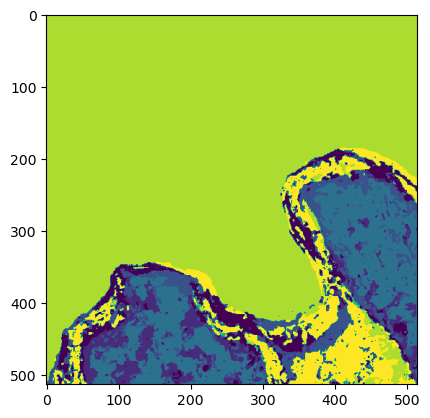

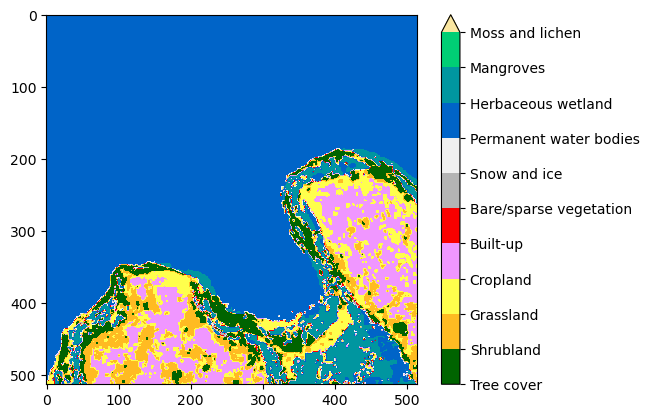

In [44]:
classes = ["Tree cover", "Shrubland", 'Grassland','Cropland', 'Built-up', 'Bare/sparse vegetation', 'Snow and ice', 'Permanent water bodies', 'Herbaceous wetland', 'Mangroves', 'Moss and lichen']

plt.imshow(val)
plt.show()
fig, ax = plt.subplots()
cax = ax.imshow(out, cmap=cmap, norm=norm)

cbar = fig.colorbar(cax, ticks=list(range(1, 12)), orientation='vertical', extendrect = False)
cbar.ax.set_yticklabels(classes)  # horizontal colorbar
plt.show()

In [20]:
def stack_norm(im, index=[2,1,0]):
    aa = np.dstack([im[:,:,i] for i in index])
    aa = (aa-aa.min())/(aa.max()-aa.min() + 0.0000001)
    return aa

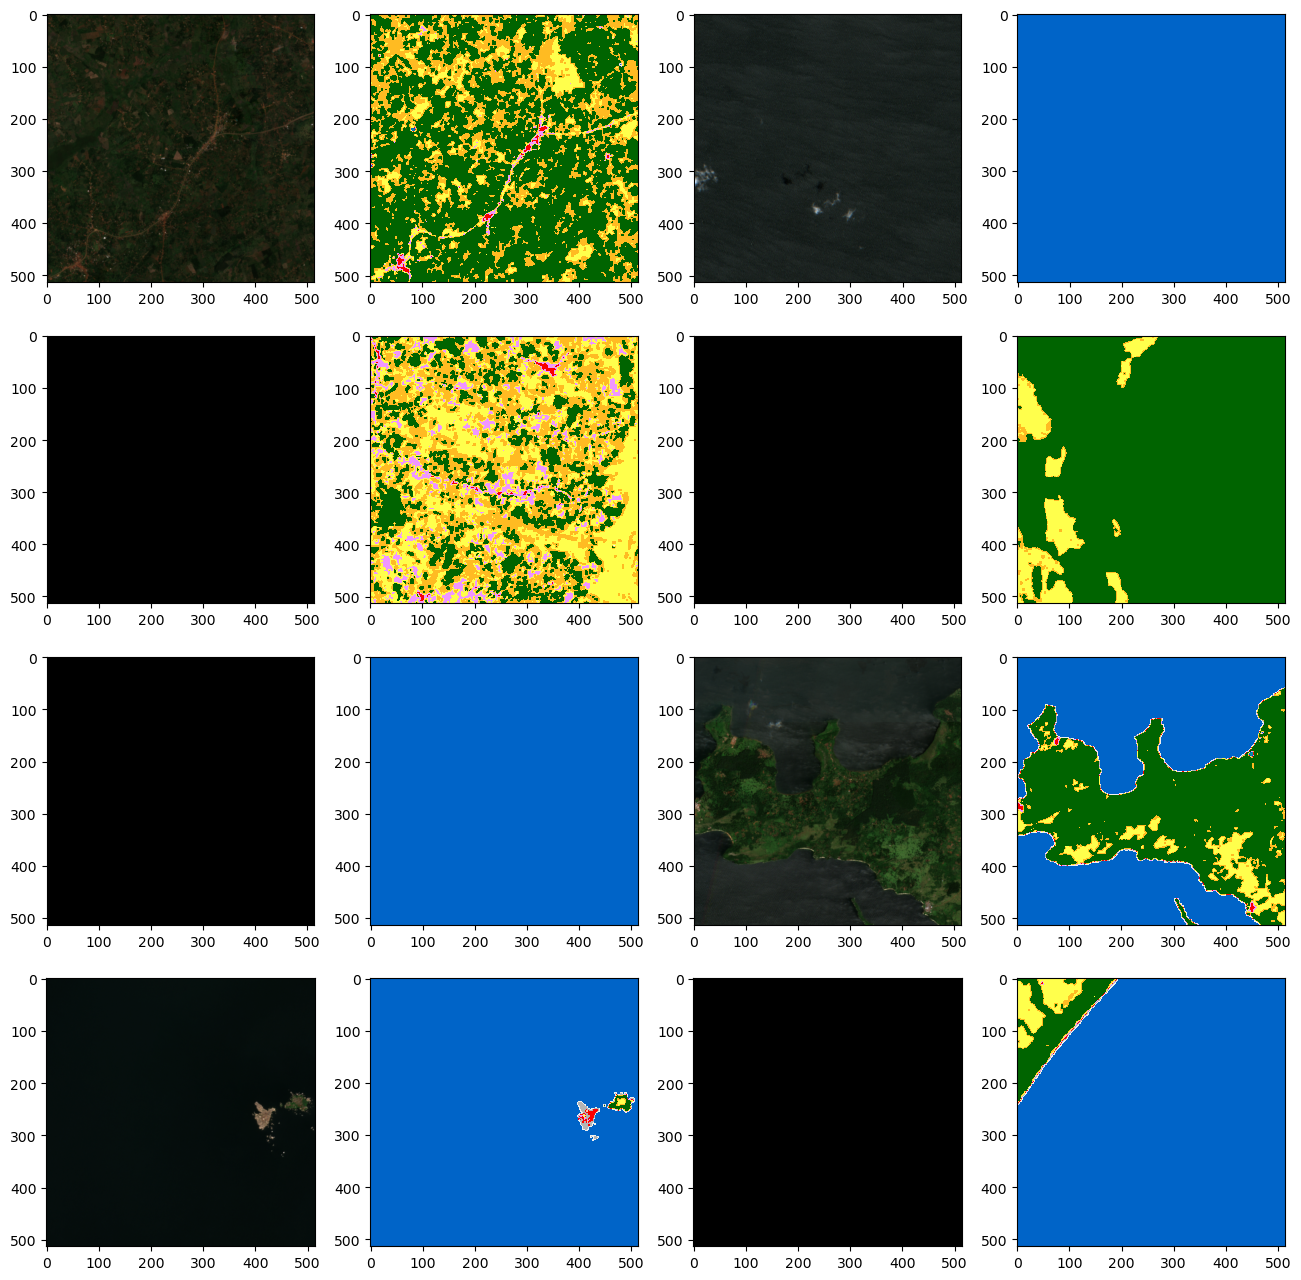

In [27]:
root_fold = '/GORILLA/IMAGES'
images = glob(f'/GORILLA/samples/train/images/*.tif')
labels = glob(f'/GORILLA/samples/train/labels/*.tif')
files = list(zip(images, labels))
fig, ax = plt.subplots(4, 4, figsize = (16, 16))
subs = random.sample(files, 4)
subs_b = random.sample(files, 4)

array_a = []
array_b = []
for i in range(len(subs)):
    im = imread(subs[i][0])
    im = stack_norm(im=im)
    
    im1 = imread(subs_b[i][0])
    im1 = stack_norm(im=im1)
    
    
    lb = imread(subs[i][1])
    lb = remapLC(lb)
    array_a.append(lb)
    
    lb1 = imread(subs_b[i][1])
    lb1 = remapLC(lb1)
    
    array_b.append(lb1)
    
    ax[i][0].imshow(im[:,:,:3])
    ax[i][1].imshow(lb, cmap=cmap, norm=norm)
    
    ax[i][2].imshow(im1[:,:,:3])
    ax[i][3].imshow(lb1, cmap=cmap, norm=norm)
    
plt.show()